In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sys
import timeit
import six
sys.modules['sklearn.externals.six'] = six
import mlrose
import mlrose_hiive
import time
import warnings
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
fig_path='D:/OMSCS/ml/Assignment2/figures'

In [2]:
# load dataset[1] Breast Cancer Data
df=pd.read_csv('D:/OMSCS/ml/Assignment1/data/cancer.csv')

# drop un-needed columns
df.drop(['id'], axis=1, inplace=True)
df.drop(['Unnamed: 32'], axis=1, inplace=True)

# update target variable from text to binary expression (Malignant to 1; benign to 0)
df.loc[df['diagnosis'] == "M", 'diagnosis'] = 1
df.loc[df['diagnosis'] == "B", 'diagnosis'] = 0

# update the target column datatype from object to float otherwise cannot fit the data
df['diagnosis'] = df['diagnosis'].astype(float)

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
id = 903657078

# split dataset into training and testing
x = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=id)

# check the dataset size and target distribution
print("total number of examples in the dataset is:", x.shape[0])
print()
print("porpotion of Malignant cases is: %.2f%% " % (y[y==1].shape[0]/y.shape[0]*100.0))

# normalize the data
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test= ss.transform(x_test)

total number of examples in the dataset is: 569

porpotion of Malignant cases is: 37.26% 


In [4]:
# set up the base model
nn_clf = MLPClassifier(hidden_layer_sizes=(30, ), 
                       activation= 'relu', 
                       solver= 'adam',
                       alpha= 0.0001, 
                       learning_rate_init=0.01, 
                       random_state=id,
                       max_iter=500)
nn_clf.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(30,), learning_rate_init=0.01, max_iter=500,
              random_state=903657078)

In [6]:
iterations_range = [2, 4, 8, 16, 32, 64, 128, 256, 512]
rhc_loss=[]
for iter in iterations_range:
    nn_model_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                              activation='relu',
                                              algorithm='random_hill_climb', 
                                              max_iters=iter,
                                              bias=True, 
                                              is_classifier=True, 
                                              learning_rate=0.01,
                                              early_stopping=True, 
                                              clip_max=5,
                                              max_attempts=500,
                                              curve=True, 
                                              random_state=id)
    nn_model_rhc.fit(x_train,y_train)
    rhc_loss.append(nn_model_rhc.loss)

In [6]:
sa_loss=[]
for iter in iterations_range:
    nn_model_sa = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                             activation='relu',
                                             algorithm='simulated_annealing', 
                                             max_iters=iter,
                                             bias=True, 
                                             is_classifier=True, 
                                             learning_rate=0.01,
                                             early_stopping=True, 
                                             clip_max=5,
                                             schedule=mlrose_hiive.GeomDecay(init_temp=1),
                                             max_attempts=500,
                                             curve=True, 
                                             random_state=id)
    nn_model_sa.fit(x_train,y_train)
    sa_loss.append(nn_model_sa.loss)

In [7]:
ga_loss=[]
for iter in iterations_range:
    nn_model_ga = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                             activation='relu',
                                             algorithm='genetic_alg', 
                                             max_iters=iter,
                                             bias=True, 
                                             is_classifier=True, 
                                             learning_rate=0.01,
                                             early_stopping=True, 
                                             clip_max=5,
                                             max_attempts=500,
                                             pop_size=100,
                                             mutation_prob=0.5,
                                             curve=True,
                                             random_state=id)
    nn_model_ga.fit(x_train,y_train)
    ga_loss.append(nn_model_ga.loss)

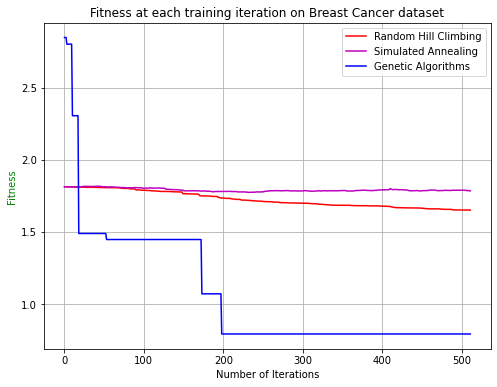

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(nn_model_rhc.fitness_curve[:,0], color="r", label='Random Hill Climbing')
plt.plot(nn_model_sa.fitness_curve[:,0], color="m", label='Simulated Annealing')
plt.plot(nn_model_ga.fitness_curve[:,0], color="b", label='Genetic Algorithms')
plt.title('Fitness at each training iteration on Breast Cancer dataset')
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness', color='g')
plt.legend(loc="best")
plt.grid()

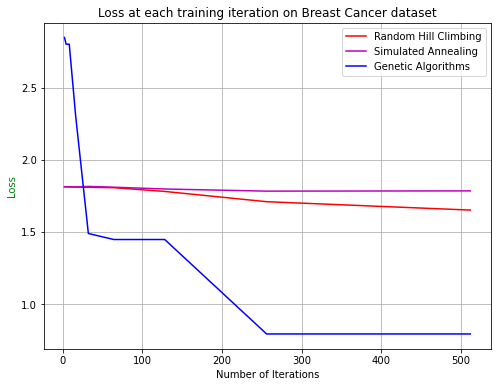

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(iterations_range, rhc_loss, color="r", label='Random Hill Climbing')
plt.plot(iterations_range, sa_loss, color="m", label='Simulated Annealing')
plt.plot(iterations_range, ga_loss, color="b", label='Genetic Algorithms')
plt.title('Loss at each training iteration on Breast Cancer dataset')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss', color='g')
plt.legend(loc="best")
plt.grid()

In [10]:
time_dict = dict()
test_dict = dict()

In [11]:
start_time = time.time()
nn_clf.fit(x_train, y_train)
end_time = time.time()
time_taken = end_time - start_time
time_dict['Base_Neural_Network'] = [time_taken]

start_time = time.time()
nn_clf.predict(x_test)
end_time = time.time()
time_taken = end_time - start_time
test_dict['Base_Neural_Network'] = [time_taken]

In [12]:
start_time = time.time()
nn_model_rhc.fit(x_train, y_train)
end_time = time.time()
time_taken = end_time - start_time
time_dict['Random_Hill_Climb'] = [time_taken]

start_time = time.time()
nn_model_rhc.predict(x_test)
end_time = time.time()
time_taken = end_time - start_time
test_dict['Random_Hill_Climb'] = [time_taken]

In [13]:
start_time = time.time()
nn_model_sa.fit(x_train, y_train)
end_time = time.time()
time_taken = end_time - start_time
time_dict['Simulated_Annealing'] = [time_taken]

start_time = time.time()
nn_model_sa.predict(x_test)
end_time = time.time()
time_taken = end_time - start_time
test_dict['Simulated_Annealing'] = [time_taken]

In [14]:
start_time = time.time()
nn_model_ga.fit(x_train, y_train)
end_time = time.time()
time_taken = end_time - start_time
time_dict['Genetic_Algorithms'] = [time_taken]

start_time = time.time()
nn_model_ga.predict(x_test)
end_time = time.time()
time_taken = end_time - start_time
test_dict['Genetic_Algorithms'] = [time_taken]

In [66]:
clf_dict = {'Base_Neural_Network': nn_clf,
            'Random_Hill_Climb': nn_model_rhc, 
            'Simulated_Annealing': nn_model_sa, 
            'Genetic_Algorithms': nn_model_ga}

In [67]:
def fun(clf_dict, x_train, y_train, x_test, y_test):
    d = dict()
    for i in clf_dict.keys():
        l = list()
        train_pred = clf_dict[i].predict(x_train)
        auc_score = accuracy_score(y_train, train_pred)
        l.append(auc_score)
        
        test_pred = clf_dict[i].predict(x_test)
        auc_score = accuracy_score(y_test, test_pred)
        l.append(auc_score)
        
        # Adding difference of score (train-test)
        diff = l[0]-l[1]
        l.append(diff)
        
        d[i] = l
        
    return d

In [68]:
# Calling the above function fun() to predict and then compare roc_auc score of different models
scores = fun(clf_dict, x_train, y_train, x_test, y_test)

IndexError: list index out of range

In [18]:
df = pd.DataFrame.from_dict(scores)
df = df.rename(index = {0:'Train_Accuracy_Score', 1:'Test_Accuracy_Score', 2:'Accuracy_Difference'})
df

,Base_Neural_Network,Random_Hill_Climb,Simulated_Annealing,Genetic_Algorithms
Train_Accuracy_Score,1.000000,0.641758,0.635165,0.956044
Test_Accuracy_Score,0.938596,0.640351,0.614035,0.964912
Accuracy_Difference,0.061404,0.001407,0.021130,-0.008868


Text(0.5, 1.0, 'Accuracy Score of base neural network & randomized optimization')

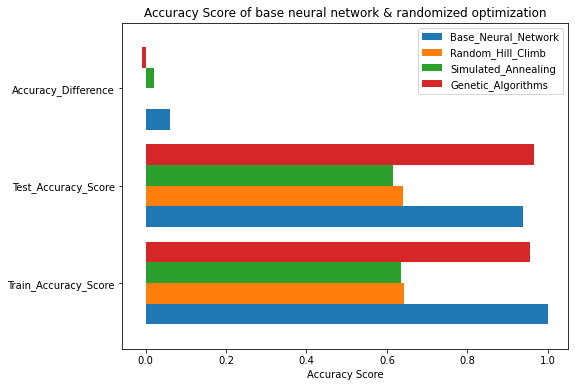

In [19]:
df.plot(kind='barh', figsize=(8, 6), zorder=2, width=0.85)
plt.xlabel('Accuracy Score')
plt.title('Accuracy Score of base neural network & randomized optimization')

In [20]:
def fun(clf_dict, x_train, y_train, x_test, y_test):
    d = dict()
    for i in clf_dict.keys():
        l = list()
        train_pred = clf_dict[i].predict(x_train)
        f1 = f1_score(y_train, train_pred)
        l.append(f1)
        
        test_pred = clf_dict[i].predict(x_test)
        f1 = f1_score(y_test, test_pred)
        l.append(f1)
        
        # Adding difference of score (train-test)
        diff = l[0]-l[1]
        l.append(diff)
        
        d[i] = l
        
    return d

# Calling the above function fun() to predict and then compare roc_auc score of different models
scores = fun(clf_dict, x_train, y_train, x_test, y_test)
df = pd.DataFrame.from_dict(scores)
df = df.rename(index = {0:'Train_F1_Score', 1:'Test_F1_Score', 2:'F1_Difference'})
df

df.plot(kind='barh', figsize=(8, 6), zorder=2, width=0.85)
plt.xlabel('F1 Score')
plt.title('F1 Score of base neural network & randomized optimization')

In [21]:
# Calling the above function fun() to predict and then compare roc_auc score of different models
scores = fun(clf_dict, x_train, y_train, x_test, y_test)
df = pd.DataFrame.from_dict(scores)
df = df.rename(index = {0:'Train_F1_Score', 1:'Test_F1_Score', 2:'F1_Difference'})
df

,Base_Neural_Network,Random_Hill_Climb,Simulated_Annealing,Genetic_Algorithms
Train_F1_Score,1.000000,0.220096,0.194175,0.942197
Test_F1_Score,0.915663,0.280702,0.185185,0.955556
F1_Difference,0.084337,-0.060606,0.008990,-0.013359


Text(0.5, 1.0, 'F1 Score of base neural network & randomized optimization')

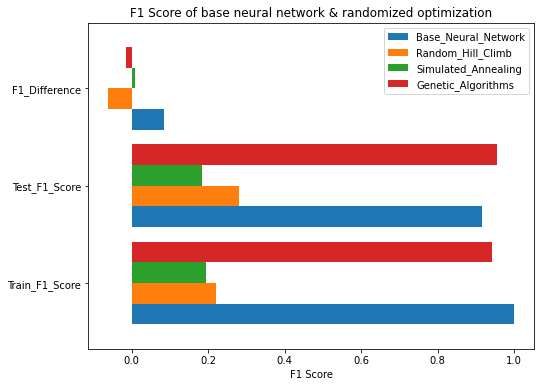

In [22]:
df.plot(kind='barh', figsize=(8, 6), zorder=2, width=0.85)
plt.xlabel('F1 Score')
plt.title('F1 Score of base neural network & randomized optimization')

In [23]:
times = pd.DataFrame.from_dict(time_dict).T
times = times.rename(index = str, columns = {0:'training_time'})
times

,training_time
Base_Neural_Network,0.121874
Random_Hill_Climb,0.668607
Simulated_Annealing,0.886132
Genetic_Algorithms,82.010907


Text(0, 0.5, 'Training Time')

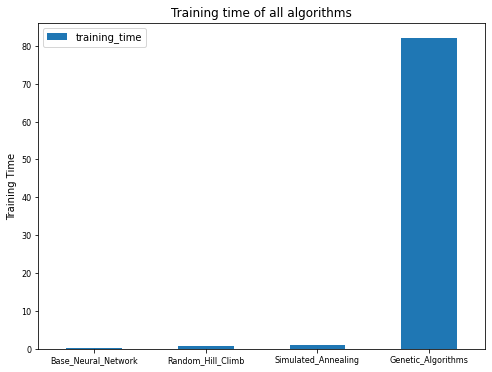

In [24]:
figure = times.plot(kind = 'bar', title = 'Training time of all algorithms', figsize = (8, 6), fontsize = 8)
plt.xticks(rotation = 360)
plt.ylabel('Training Time')

# RHC

In [5]:
iterations_range = np.arange(1000, 20000, 2000).tolist()
rhc_loss=[]
for iter in iterations_range:
    nn_model_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                              activation='relu',
                                              algorithm='random_hill_climb', 
                                              max_iters=iter,
                                              bias=True, 
                                              is_classifier=True, 
                                              learning_rate=0.01,
                                              early_stopping=True,
                                              max_attempts=500,
                                              curve=True, 
                                              random_state=id)
    nn_model_rhc.fit(x_train,y_train)
    rhc_loss.append(nn_model_rhc.loss)

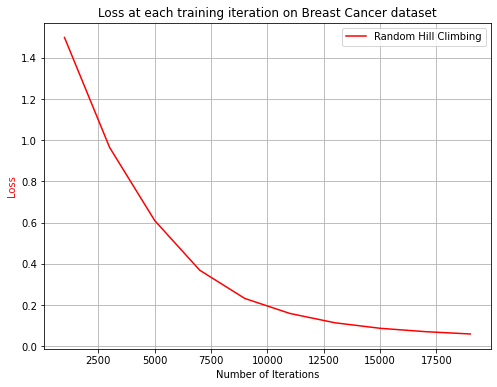

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(iterations_range, rhc_loss, color="r", label='Random Hill Climbing')
plt.title('Loss at each training iteration on Breast Cancer dataset')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss', color='r')
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'RHC_loss_iteration.png')

No handles with labels found to put in legend.


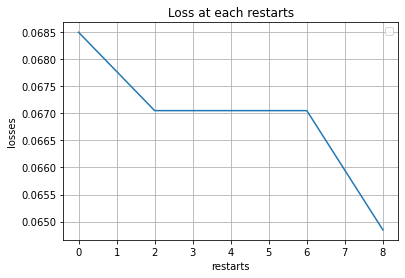

In [7]:
restarts= [0, 2, 4, 6 ,8]
rhc_loss=[]
for i in restarts:
    nn_model_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                              activation='relu',
                                              algorithm='random_hill_climb', 
                                              max_iters=17500,
                                              bias=True, 
                                              is_classifier=True, 
                                              learning_rate=0.01,
                                              early_stopping=True,
                                              max_attempts=500,
                                              curve=True, 
                                              random_state=id,
                                              restarts=i)
    nn_model_rhc.fit(x_train,y_train)
    rhc_loss.append(nn_model_rhc.loss)

plt.plot(restarts, rhc_loss)
plt.xlabel('restarts')
plt.ylabel('losses')
plt.title('Loss at each restarts')
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'RHC_loss_restart.png')

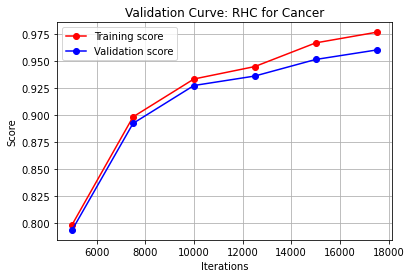

In [10]:
from sklearn.model_selection import validation_curve
iterations_range = np.arange(5*10**3, 2*10**4, 2.5*10**3).tolist()
nn_model_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                              activation='relu',
                                              algorithm='random_hill_climb', 
                                              bias=True, 
                                              is_classifier=True, 
                                              learning_rate=0.01,
                                              early_stopping=True,
                                              max_attempts=500,
                                              curve=True, 
                                              random_state=id,
                                              restarts=5)
train_scores, test_scores = validation_curve(nn_model_rhc, x_train, y_train, param_name="max_iters", param_range=iterations_range, n_jobs=4, cv=5, scoring='accuracy')

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(iterations_range, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(iterations_range, test_scores_mean, 'o-', color='b', label='Validation score')


plt.title('Validation Curve: RHC for Cancer')
plt.xlabel('Iterations')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'RHC_accuracy_iteration.png')

# Simulated Annealing

No handles with labels found to put in legend.


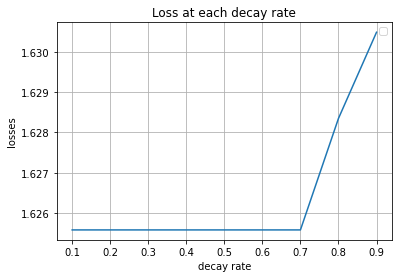

In [11]:
decay_rate = np.arange(0.1, 1.0, 0.1).tolist()
sa_loss=[]
for i in decay_rate:
    nn_model_sa = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                             activation='relu',
                                             algorithm='simulated_annealing', 
                                             max_iters=1000,
                                             bias=True, 
                                             is_classifier=True, 
                                             learning_rate=0.01,
                                             early_stopping=True,
                                             max_attempts=500,
                                             curve=True, 
                                             random_state=id,
                                             schedule=mlrose_hiive.GeomDecay(init_temp=5, decay=i))
    nn_model_sa.fit(x_train,y_train)
    sa_loss.append(nn_model_sa.loss)

plt.plot(decay_rate, sa_loss)
plt.xlabel('decay rate')
plt.ylabel('losses')
plt.title('Loss at each decay rate')
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'SA_loss_decay.png')

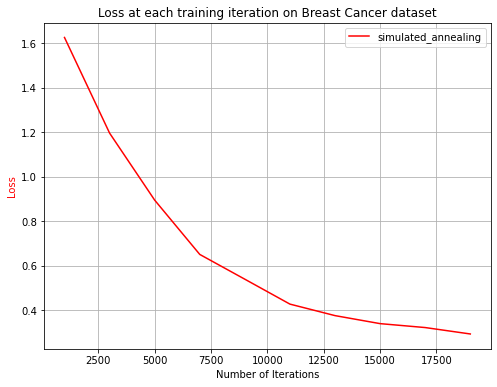

In [12]:
iterations_range = np.arange(1000, 20000, 2000).tolist()
sa_loss=[]
for iter in iterations_range:
    nn_model_sa = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                             activation='relu',
                                             algorithm='simulated_annealing', 
                                             max_iters=iter,
                                             bias=True, 
                                             is_classifier=True, 
                                             learning_rate=0.01,
                                             early_stopping=True,
                                             max_attempts=500,
                                             curve=True, 
                                             random_state=id,
                                             schedule=mlrose_hiive.GeomDecay(init_temp=5.0, decay=0.5))
    nn_model_sa.fit(x_train,y_train)
    sa_loss.append(nn_model_sa.loss)

plt.figure(figsize=(8, 6))
plt.plot(iterations_range, sa_loss, color="r", label='simulated_annealing')
plt.title('Loss at each training iteration on Breast Cancer dataset')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss', color='r')
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'SA_loss_iteration.png')

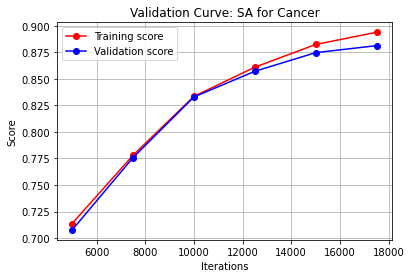

In [13]:
# from sklearn.model_selection import validation_curve
iterations_range = np.arange(5*10**3, 2*10**4, 2.5*10**3).tolist()
nn_model_sa = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                         activation='relu',
                                         algorithm='simulated_annealing',
                                         bias=True, 
                                         is_classifier=True, 
                                         learning_rate=0.01,
                                         early_stopping=True,
                                         max_attempts=500,
                                         curve=True, 
                                         random_state=id,
                                         schedule=mlrose_hiive.GeomDecay(init_temp=5.0, decay=0.5))

train_scores, test_scores = validation_curve(nn_model_sa, x_train, y_train, param_name="max_iters", param_range=iterations_range, n_jobs=4, cv=5, scoring='accuracy')

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(iterations_range, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(iterations_range, test_scores_mean, 'o-', color='b', label='Validation score')


plt.title('Validation Curve: SA for Cancer')
plt.xlabel('Iterations')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'SA_accuracy_iteration.png')

# Genetic Algorithm

No handles with labels found to put in legend.


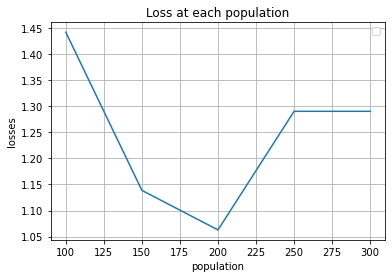

In [14]:
population = np.arange(100, 350, 50).tolist()
ga_loss=[]
for iter in population:
    nn_model_ga = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                             activation='relu',
                                             algorithm='genetic_alg', 
                                             max_iters=500,
                                             bias=True, 
                                             is_classifier=True, 
                                             learning_rate=0.01,
                                             early_stopping=True,
                                             max_attempts=500,
                                             pop_size=iter,
                                             mutation_prob=0.5,
                                             curve=True,
                                             random_state=id)
    nn_model_ga.fit(x_train,y_train)
    ga_loss.append(nn_model_ga.loss)

plt.plot(population, ga_loss)
plt.xlabel('population')
plt.ylabel('losses')
plt.title('Loss at each population')
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'GA_loss_pop_size.png')

No handles with labels found to put in legend.


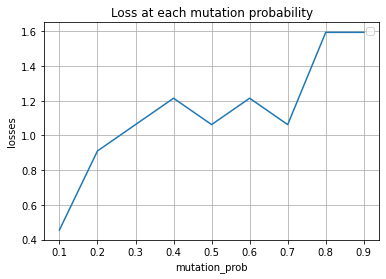

In [15]:
mutation = np.arange(0.1, 1.0, 0.1).tolist()
ga_loss=[]
for iter in mutation:
    nn_model_ga = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                             activation='relu',
                                             algorithm='genetic_alg', 
                                             max_iters=500,
                                             bias=True, 
                                             is_classifier=True, 
                                             learning_rate=0.01,
                                             early_stopping=True,
                                             max_attempts=500,
                                             pop_size=200,
                                             mutation_prob=iter,
                                             curve=True,
                                             random_state=id)
    nn_model_ga.fit(x_train,y_train)
    ga_loss.append(nn_model_ga.loss)

plt.plot(mutation, ga_loss)
plt.xlabel('mutation_prob')
plt.ylabel('losses')
plt.title('Loss at each mutation probability')
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'GA_loss_mutation.png')

In [16]:
iterations_range = np.arange(100, 1600, 100).tolist()
ga_loss=[]
for iter in iterations_range:
    nn_model_ga = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                             activation='relu',
                                             algorithm='genetic_alg', 
                                             max_iters=iter,
                                             bias=True, 
                                             is_classifier=True, 
                                             learning_rate=0.01,
                                             early_stopping=True,
                                             max_attempts=500,
                                             pop_size=200,
                                             mutation_prob=0.1,
                                             curve=True,
                                             random_state=id)
    nn_model_ga.fit(x_train,y_train)
    ga_loss.append(nn_model_ga.loss)

plt.figure(figsize=(8, 6))
plt.plot(iterations_range, ga_loss, color="r", label='genetic_alg')
plt.title('Loss at each training iteration on Breast Cancer dataset')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss', color='r')
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'GA_loss_iteration.png')

KeyboardInterrupt: 

In [ ]:
# from sklearn.model_selection import validation_curve
iterations_range = np.arange(100, 1000, 100).tolist()
train_scores, test_scores = validation_curve(nn_model_ga, x_train, y_train, param_name="max_iters", param_range=iterations_range, n_jobs=4, cv=5, scoring='accuracy')

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(iterations_range, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(iterations_range, test_scores_mean, 'o-', color='b', label='Validation score')


plt.title('Validation Curve: GA for Cancer')
plt.xlabel('Iterations')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path+'GA_accuracy_iteration.png')

In [ ]:
nn_model_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                          activation='relu',
                                          algorithm='random_hill_climb', 
                                          max_iters=17500,
                                          learning_rate=0.01,
                                          early_stopping=True,
                                          max_attempts=500,
                                          curve=True, 
                                          restarts=5,
                                          random_state=id)
nn_model_rhc.fit(x_train,y_train)

nn_model_sa = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                         activation='relu',
                                         algorithm='simulated_annealing', 
                                         max_iters=17500,
                                         learning_rate=0.01,
                                         early_stopping=True,
                                         schedule=mlrose_hiive.GeomDecay(init_temp=5, decay=0.5),
                                         max_attempts=500,
                                         curve=True, 
                                         random_state=id)
nn_model_sa.fit(x_train,y_train)

nn_model_ga = mlrose_hiive.NeuralNetwork(hidden_nodes=[30], 
                                         activation='relu',
                                         algorithm='genetic_alg', 
                                         max_iters=500, 
                                         learning_rate=0.01,
                                         early_stopping=True,
                                         max_attempts=500,
                                         pop_size=200,
                                         mutation_prob=0.1,
                                         curve=True,
                                         random_state=id)
nn_model_ga.fit(x_train,y_train)

In [ ]:
clf_dict = {'Base_Neural_Network': nn_clf,
            'Random_Hill_Climb': nn_model_rhc, 
            'Simulated_Annealing': nn_model_sa, 
            'Genetic_Algorithms': nn_model_ga}

def fun(clf_dict, x_train, y_train, x_test, y_test):
    d = dict()
    for i in clf_dict.keys():
        l = list()
        train_pred = clf_dict[i].predict(x_train)
        auc_score = accuracy_score(y_train, train_pred)
        l.append(auc_score)
        
        test_pred = clf_dict[i].predict(x_test)
        auc_score = accuracy_score(y_test, test_pred)
        l.append(auc_score)
        
        # Adding difference of score (train-test)
        diff = l[0]-l[1]
        l.append(diff)
        
        d[i] = l
        
    return d

# Calling the above function fun() to predict and then compare roc_auc score of different models
scores = fun(clf_dict, x_train, y_train, x_test, y_test)

df = pd.DataFrame.from_dict(scores)
df = df.rename(index = {0:'Train_Accuracy_Score', 1:'Test_Accuracy_Score', 2:'Accuracy_Difference'})
df

In [ ]:
df.plot(kind='barh', figsize=(8, 6), zorder=2, width=0.85)
plt.xlabel('Accuracy Score')
plt.title('Accuracy Score of base neural network & randomized optimization')
plt.grid()
plt.savefig(fig_path+'all_algorithms_accuracy.png')

In [ ]:
def fun(clf_dict, x_train, y_train, x_test, y_test):
    d = dict()
    for i in clf_dict.keys():
        l = list()
        train_pred = clf_dict[i].predict(x_train)
        f1 = f1_score(y_train, train_pred)
        l.append(f1)
        
        test_pred = clf_dict[i].predict(x_test)
        f1 = f1_score(y_test, test_pred)
        l.append(f1)
        
        # Adding difference of score (train-test)
        diff = l[0]-l[1]
        l.append(diff)
        
        d[i] = l
        
    return d

# Calling the above function fun() to predict and then compare roc_auc score of different models
scores = fun(clf_dict, x_train, y_train, x_test, y_test)
df = pd.DataFrame.from_dict(scores)
df = df.rename(index = {0:'Train_F1_Score', 1:'Test_F1_Score', 2:'F1_Difference'})
df

In [ ]:
df.plot(kind='barh', figsize=(8, 6), zorder=2, width=0.85)
plt.xlabel('F1 Score')
plt.title('F1 Score of base neural network & randomized optimization')
plt.grid()
plt.savefig(fig_path+'all_algorithms_f1.png')

In [ ]:
time_dict = dict()

start_time = time.time()
nn_clf.fit(x_train, y_train)
end_time = time.time()
time_taken = end_time - start_time
time_dict['Base_Neural_Network'] = [time_taken]

start_time = time.time()
nn_model_rhc.fit(x_train, y_train)
end_time = time.time()
time_taken = end_time - start_time
time_dict['Random_Hill_Climb'] = [time_taken]

start_time = time.time()
nn_model_sa.fit(x_train, y_train)
end_time = time.time()
time_taken = end_time - start_time
time_dict['Simulated_Annealing'] = [time_taken]

start_time = time.time()
nn_model_ga.fit(x_train, y_train)
end_time = time.time()
time_taken = end_time - start_time
time_dict['Genetic_Algorithms'] = [time_taken]

times = pd.DataFrame.from_dict(time_dict).T
times = times.rename(index = str, columns = {0:'training_time'})
times

In [ ]:
figure = times.plot(kind = 'bar', title = 'Training time of all algorithms', figsize = (8, 6), fontsize = 8)
plt.xticks(rotation = 360)
plt.ylabel('Training Time')
plt.grid()
plt.savefig(fig_path+'all_algorithms_run_time.png')